## Introduction

In [1]:
!pygmentize helper_scripts/lda.py

from gensim import corpora, models
import pyLDAvis
import pyLDAvis.gensim
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from tqdm import tqdm

plt.rcParams["figure.figsize"] = (22, 10)
plt.style.use("seaborn-whitegrid")


class LDA:
    def __init__(self, training_samples):
        self.texts = training_samples
        self.docs = [data.split() for data in self.texts]
        self.dictionary = corpora.Dictionary(self.docs)
        self.bow_corpus = [self.dictionary.doc2bow(doc) for doc in self.docs]

    def __iter__(self):
        self.length = len(self.texts)
        self.n = 0
        return self

    def __next__(self):
        token = self.bow_corpus[self.n]
        self.n += 1
        if self.n == self.length:
            self.n == 1
        return [(self.dictionary[ii], freq) for ii, freq in token]

    def filter_extremes(self, keep_n, no_below, no_above):
        self.dictionary.filter_extremes(
            keep_n=keep_n, no_below=no_below,

## Jupyter Notebook Setup

In [2]:
%load_ext autoreload
%autoreload 2

from helper_scripts.lda import LDA
import re
import pandas as pd
import numpy as np
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Setup before git push.
'''
Change the default plotly renderer to colab 
because plotly's plot doesn't render on the 
internet outside of certain Python environments.
Use iframe if rendering in localhost.
'''
import plotly.io as pio
# pio.renderers.default = 'iframe' # for localhost
pio.renderers.default = 'colab' # before git commit
# Rerun all cells with plotly plots after running this cell (before git commit).

## Reading The Data

In [4]:
df = pd.read_parquet('../cleaned_data/cleaned_reviews.parquet.gzip')
df.head()

title       date location  \
0  Which iPhone you should Purchase ? iPhone 8, X... 2018-12-12    India   
1                   Don't buy iPhone xr from Amazon. 2018-11-17    India   
2                            Happy with the purchase 2019-01-27    India   
3  Amazon is not an apple authorised reseller. Pl... 2019-05-02    India   
4       Excellent Battery life and buttery smooth UI 2019-05-24    India   

   rating                                               text  \
0     3.0  NOTE:@ This is detailed comparison between iPh...   
1     1.0  Very bad experience with this iPhone xr phone....   
2     5.0  Amazing phone with amazing camera coming from ...   
3     1.0  So I got the iPhone XR just today. The product...   
4     5.0  I've been an android user all my life until I ...   

                         title_clean  \
0   iphone purchase iphone 8 x xs xr   
1         don t buy iphone xr amazon   
2                           purchase   
3         amazon apple reseller note   
4  excellent battery life buttery ui   

                                          text_clean  
0  note comparison iphone 8 x xs xr month state b...  
1  experience iphone xr camera find amazon haven ...  
2           camera come iphone 7 plus service amazon  
3  get iphone xr today product look face d work g...  
4  ve android user life decide try iphone xr ios ...

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3277 entries, 0 to 3276
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   title        3277 non-null   object        
 1   date         3277 non-null   datetime64[ns]
 2   location     3277 non-null   object        
 3   rating       3277 non-null   float32       
 4   text         3277 non-null   object        
 5   title_clean  3277 non-null   object        
 6   text_clean   3277 non-null   object        
dtypes: datetime64[ns](1), float32(1), object(5)
memory usage: 166.5+ KB


## LDA

### Initializing the model

In [51]:
lda_model = LDA(df['text_clean'])

In [32]:
# sanity check on data
it = iter(lda_model)
it = next(it)
it.insert(0, ('word', 'frequency'))
it[:30]

[('word', 'frequency'),
 ('1', 1),
 ('11', 1),
 ('12', 1),
 ('14', 1),
 ('15', 1),
 ('16', 1),
 ('18', 1),
 ('20', 1),
 ('4', 3),
 ('4k', 1),
 ('5', 1),
 ('6', 3),
 ('64', 1),
 ('7', 2),
 ('75kxr', 1),
 ('77kxs', 1),
 ('8', 19),
 ('80k', 1),
 ('9', 1),
 ('99k', 1),
 ('accord', 1),
 ('aluminum', 1),
 ('appear', 1),
 ('battery', 4),
 ('body', 1),
 ('budget', 2),
 ('build', 1),
 ('button', 1),
 ('camera', 3)]

In [56]:
lda_model = LDA(df['text_clean'])
lda_model.filter_extremes(keep_n=10000, no_below=10,  no_above = 0.3)
# sanity check on dictionary size
len(lda_model.dictionary)

417

### Training & evaluating the model

In [58]:
lda_model.fit(4)
## Evaluate the model
lda_model.print_output()

Topic: 0	Coherence Score: 0.3885
Words: 0.066*"quality" + 0.063*"camera" + 0.038*"price" + 0.035*"battery" + 0.025*"product" + 0.022*"get" + 0.021*"life" + 0.019*"face" + 0.019*"work" + 0.018*"fingerprint"

########

Topic: 1	Coherence Score: 0.4855
Words: 0.099*"iphone" + 0.049*"xr" + 0.025*"camera" + 0.025*"love" + 0.018*"mobile" + 0.018*"buy" + 0.018*"apple" + 0.018*"👍" + 0.017*"battery" + 0.015*"experience"

########

Topic: 2	Coherence Score: 0.4082
Words: 0.117*"product" + 0.074*"battery" + 0.048*"life" + 0.047*"apple" + 0.035*"amazon" + 0.027*"camera" + 0.025*"buy" + 0.024*"money" + 0.022*"iphone" + 0.019*"price"

########

Topic: 3	Coherence Score: 0.6465
Words: 0.023*"iphone" + 0.021*"face" + 0.021*"battery" + 0.019*"camera" + 0.018*"apple" + 0.018*"s" + 0.016*"day" + 0.016*"android" + 0.015*"feature" + 0.014*"screen"

########

Perplexity Score: -5.5236 
Overall Coherence Score: 0.4822


In [59]:
lda_model.score(df.sample(500)['text_clean'].apply(lambda x: x.split()), return_per_topic=True)

(0.4420751865130672,
 [0.3899309328149731,
  0.5039296885335441,
  0.3868581240642642,
  0.4875820006394874])

### Visualizing training results

In [60]:
lda_model.visualize_topics_

### Hyperparameter tuning

tuning: 100%|██████████| 59/59 [07:42<00:00,  7.83s/it, max_coherence_score=0.504, best_params={'num_topics': 7, 'alpha': 'symmetric', 'beta': 'symmetric'}]


Finished hyperparameter tuning, model updated!


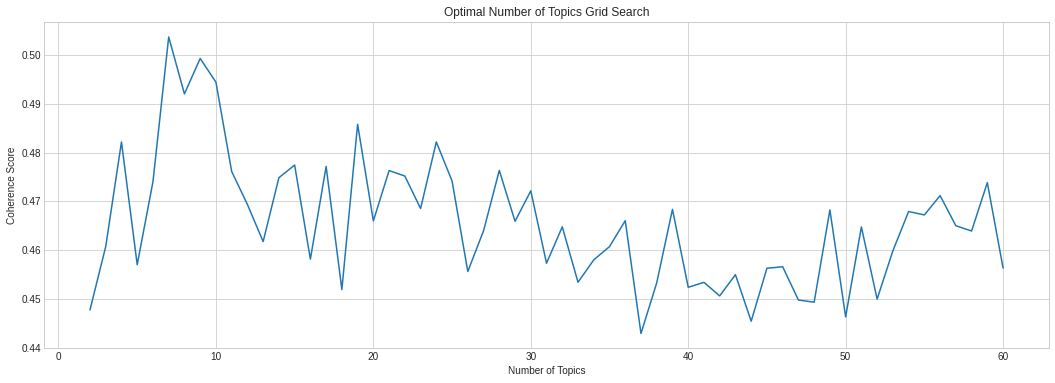

In [62]:
lda_model.find_best_num_topics()

In [63]:
best_k = lda_model.best_params_["num_topics"]

lda_model.tune(num_topic_range=range(best_k -2, best_k + 3, 1))

tuning: 100%|██████████| 210/210 [19:35<00:00,  5.60s/it, max_coherence_score=0.529, best_params={'num_topics': 7, 'alpha': 'asymmetric', 'beta': 1.0}] 


Finished hyperparameter tuning, model updated!


In [64]:
best_k = lda_model.best_params_["num_topics"]
alpha_range = list(np.arange(0.0, 1.1, 0.1))
alpha_range.append("symmetric")
alpha_range.append("asymmetric")
beta_range = list(np.arange(0.55, 1.01, 0.05))
beta_range.append("symmetric")

lda_model.tune(num_topic_range=range(best_k -1, best_k + 2, 1), alpha_range=alpha_range, beta_range=beta_range)

tuning: 100%|██████████| 429/429 [40:40<00:00,  5.69s/it, max_coherence_score=0.533, best_params={'num_topics': 7, 'alpha': 'asymmetric', 'beta': 0.8500000000000003}]


Finished hyperparameter tuning, model updated!


## LDA Result & Post Modeling Analysis

In [65]:
lda_model.fit(**lda_model.best_params_, predict_training_samples=True)

lda_model.print_output()

Topic: 0	Coherence Score: 0.3446
Words: 0.092*"product" + 0.058*"battery" + 0.056*"camera" + 0.049*"quality" + 0.032*"price" + 0.032*"life" + 0.021*"money" + 0.017*"superb" + 0.016*"iphone" + 0.016*"value"

########

Topic: 1	Coherence Score: 0.4778
Words: 0.111*"iphone" + 0.056*"xr" + 0.037*"love" + 0.025*"camera" + 0.024*"👍" + 0.018*"apple" + 0.016*"buy" + 0.015*"use" + 0.015*"battery" + 0.014*"charge"

########

Topic: 2	Coherence Score: 0.4708
Words: 0.073*"battery" + 0.064*"apple" + 0.054*"life" + 0.044*"product" + 0.037*"buy" + 0.030*"performance" + 0.026*"like" + 0.022*"iphone" + 0.020*"camera" + 0.016*"amazon"

########

Topic: 3	Coherence Score: 0.6484
Words: 0.022*"s" + 0.021*"👌" + 0.019*"iphone" + 0.019*"android" + 0.018*"battery" + 0.018*"t" + 0.017*"look" + 0.016*"day" + 0.016*"device" + 0.015*"ios"

########

Topic: 4	Coherence Score: 0.5249
Words: 0.048*"amazon" + 0.037*"face" + 0.032*"product" + 0.027*"iphone" + 0.022*"thank" + 0.022*"apple" + 0.021*"get" + 0.018*"camer

In [75]:
import re

In [135]:
topic_names = [
    "Product in General (Battery, Camera, Price)",
    "iPhone XR's Camera & Battery",
    "Battery Life, Something About Apple, Performance",
    "Comparison With Android",
    "Amazon",
    "Complaints (Problem With Product, Missing Item, Disappointment)",
    "Comparison With Other Phones (One or more specific phones, could be an iPhone, android or other phones)"
]


topics = '''Topic: 0	Coherence Score: 0.3446
Words: 0.092*"product" + 0.058*"battery" + 0.056*"camera" + 0.049*"quality" + 0.032*"price" + 0.032*"life" + 0.021*"money" + 0.017*"superb" + 0.016*"iphone" + 0.016*"value"

########

Topic: 1	Coherence Score: 0.4778
Words: 0.111*"iphone" + 0.056*"xr" + 0.037*"love" + 0.025*"camera" + 0.024*"👍" + 0.018*"apple" + 0.016*"buy" + 0.015*"use" + 0.015*"battery" + 0.014*"charge"

########

Topic: 2	Coherence Score: 0.4708
Words: 0.073*"battery" + 0.064*"apple" + 0.054*"life" + 0.044*"product" + 0.037*"buy" + 0.030*"performance" + 0.026*"like" + 0.022*"iphone" + 0.020*"camera" + 0.016*"amazon"

########

Topic: 3	Coherence Score: 0.6484
Words: 0.022*"s" + 0.021*"👌" + 0.019*"iphone" + 0.019*"android" + 0.018*"battery" + 0.018*"t" + 0.017*"look" + 0.016*"day" + 0.016*"device" + 0.015*"ios"

########

Topic: 4	Coherence Score: 0.5249
Words: 0.048*"amazon" + 0.037*"face" + 0.032*"product" + 0.027*"iphone" + 0.022*"thank" + 0.022*"apple" + 0.021*"get" + 0.018*"camera" + 0.017*"d" + 0.016*"day"

########

Topic: 5	Coherence Score: 0.5408
Words: 0.019*"n" + 0.017*"bill" + 0.017*"problem" + 0.015*"osm" + 0.015*"box" + 0.014*"miss" + 0.012*"batter" + 0.011*"gift" + 0.011*"mobile" + 0.011*"disappoint"

########

Topic: 6	Coherence Score: 0.7270
Words: 0.032*"iphone" + 0.017*"7" + 0.016*"year" + 0.016*"apple" + 0.015*"price" + 0.014*"8" + 0.013*"3" + 0.013*"like" + 0.012*"design" + 0.012*"6"'''

topics = re.findall('(Topic: \d|Words:.*)', topics)

assert len(topics) / 2 == len(topic_names), "Number of given names doesn't match number of topics!"

topics = {k:', '.join(re.findall('"\w+"', topics[i + 1])) for k, i in zip(topic_names, range(0, len(topics), 2))}

for k, v in topics.items():
    print('topic:', k)
    print('words:', v, end='\n*****\n\n')

topic: Product in General (Battery, Camera, Price)
words: "product", "battery", "camera", "quality", "price", "life", "money", "superb", "iphone", "value"
*****

topic: iPhone XR's Camera & Battery
words: "iphone", "xr", "love", "camera", "apple", "buy", "use", "battery", "charge"
*****

topic: Battery Life, Something About Apple, Performance
words: "battery", "apple", "life", "product", "buy", "performance", "like", "iphone", "camera", "amazon"
*****

topic: Comparison With Android
words: "s", "iphone", "android", "battery", "t", "look", "day", "device", "ios"
*****

topic: Amazon
words: "amazon", "face", "product", "iphone", "thank", "apple", "get", "camera", "d", "day"
*****

topic: Complaints (Problem With Product, Missing Item, Disappointment)
words: "n", "bill", "problem", "osm", "box", "miss", "batter", "gift", "mobile", "disappoint"
*****

topic: Comparison With Other Phones (One or more specific phones, could be an iPhone, android or other phones)
words: "iphone", "7", "year",

In [136]:
lda_model.visualize_topics_

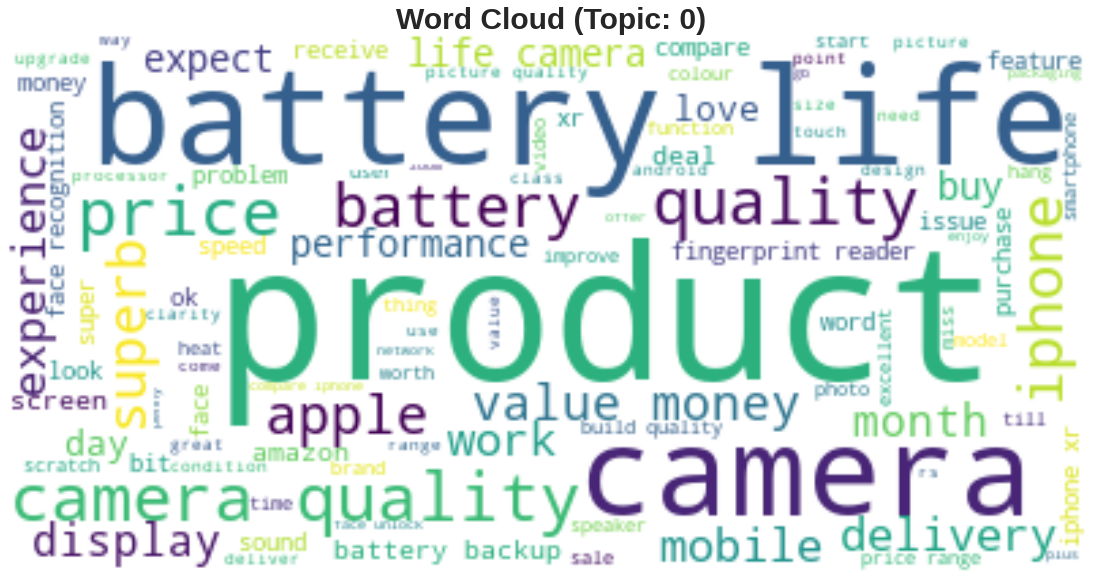

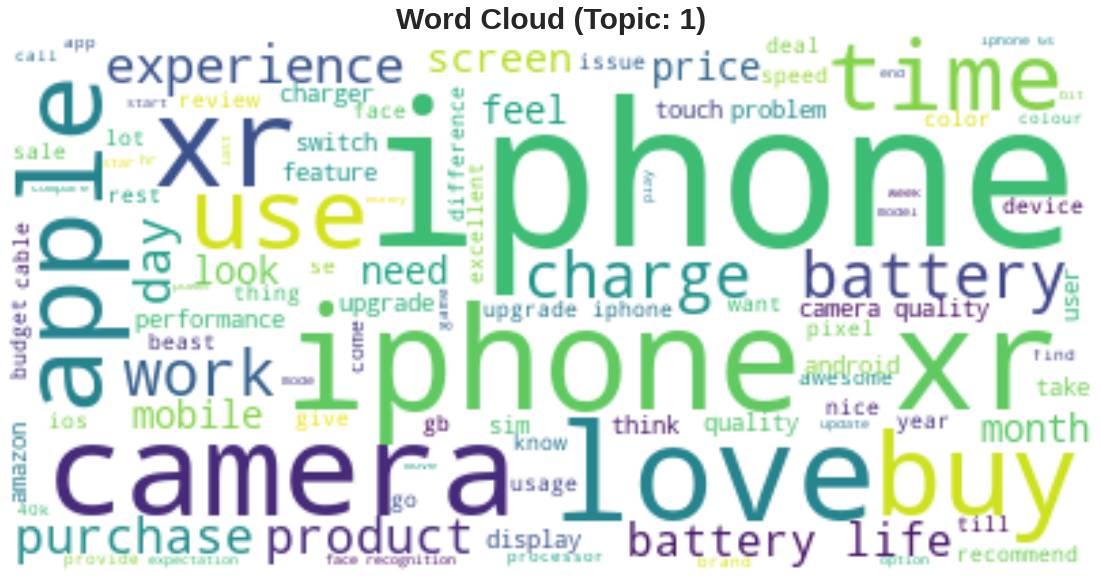

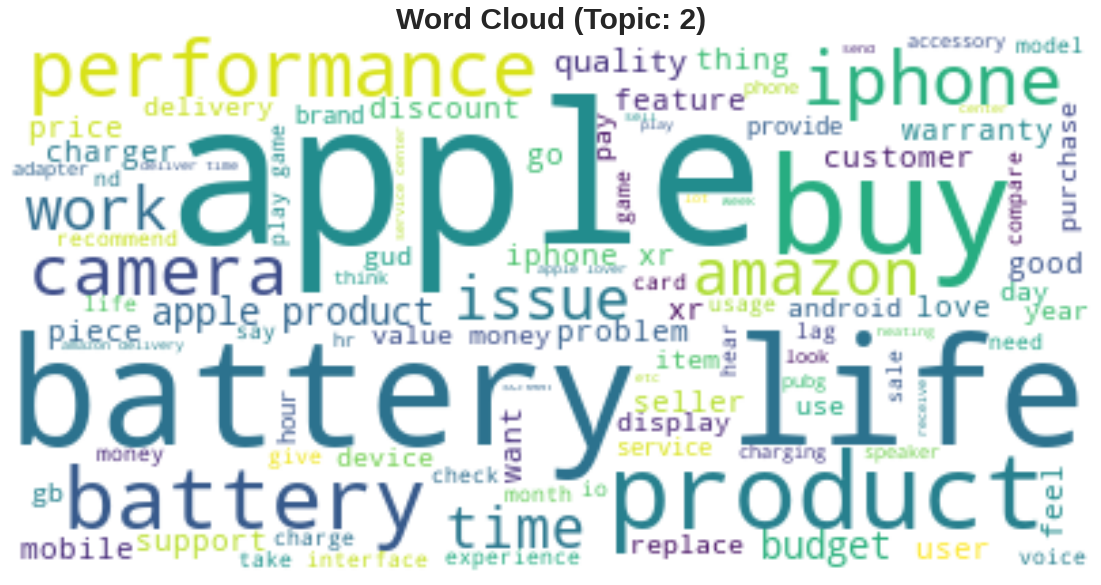

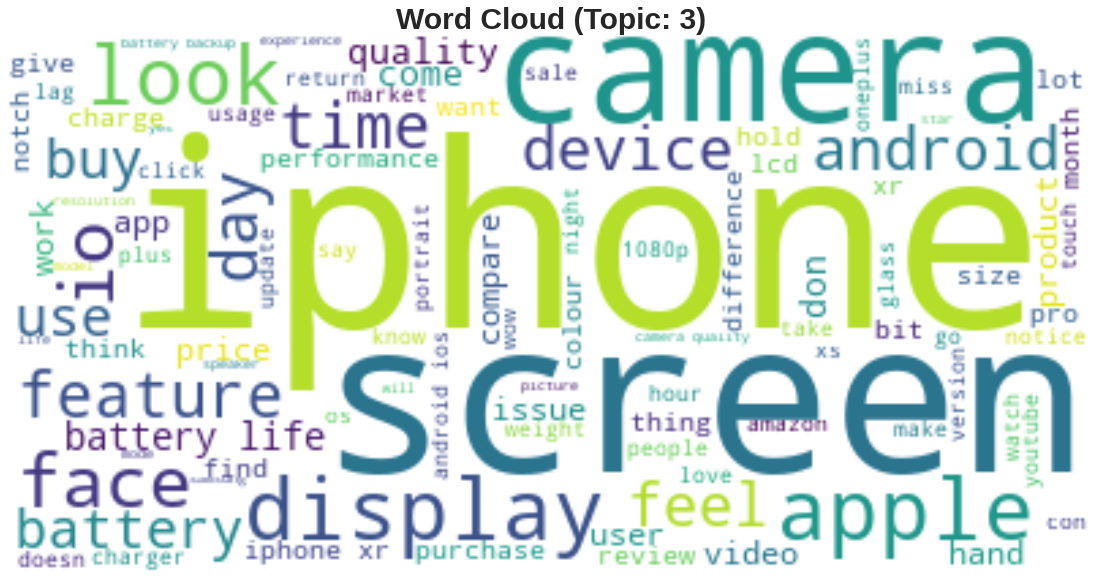

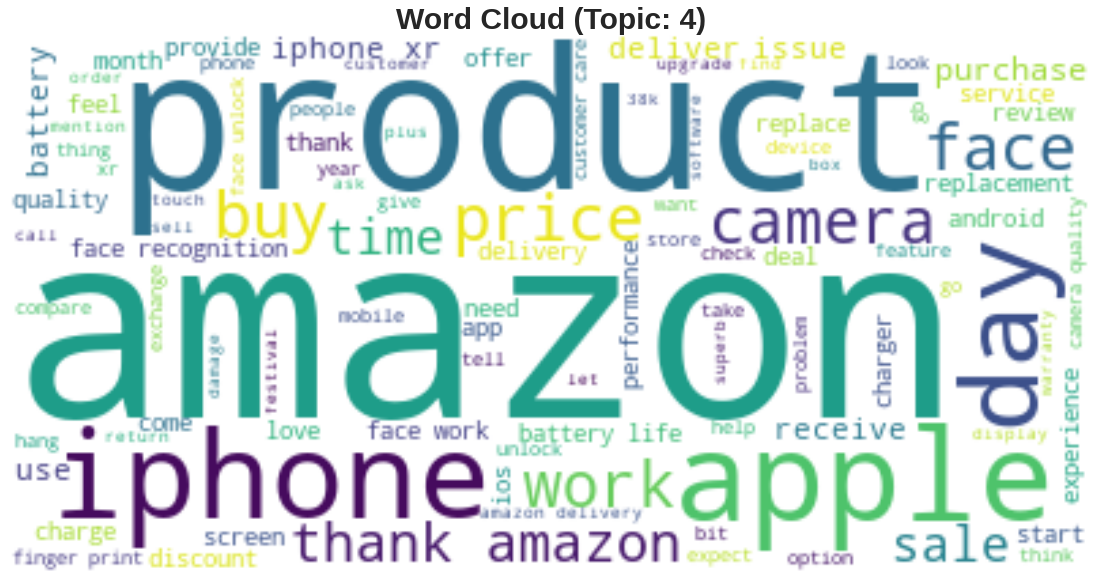

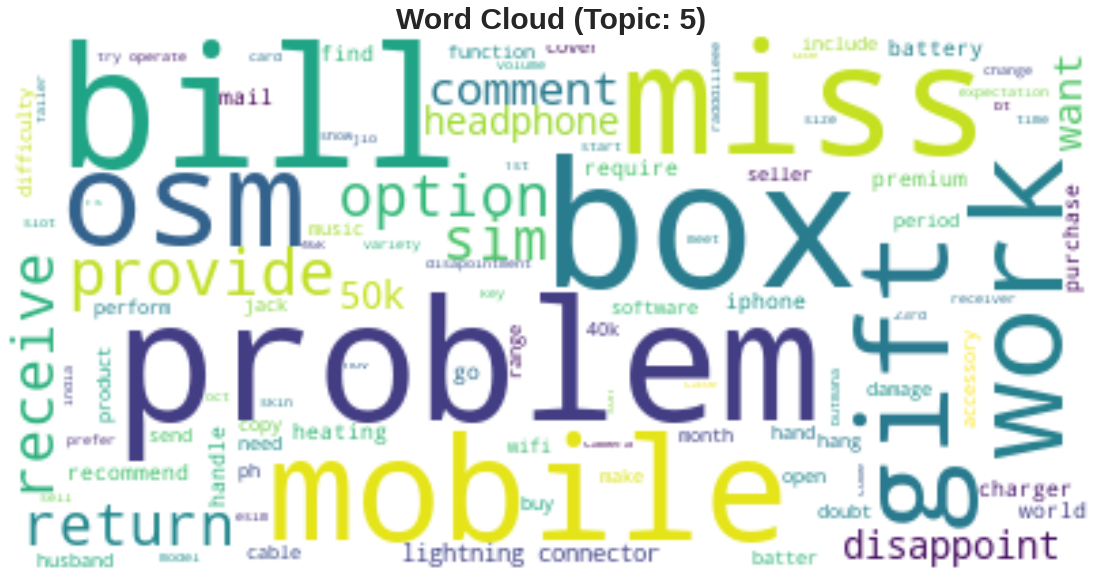

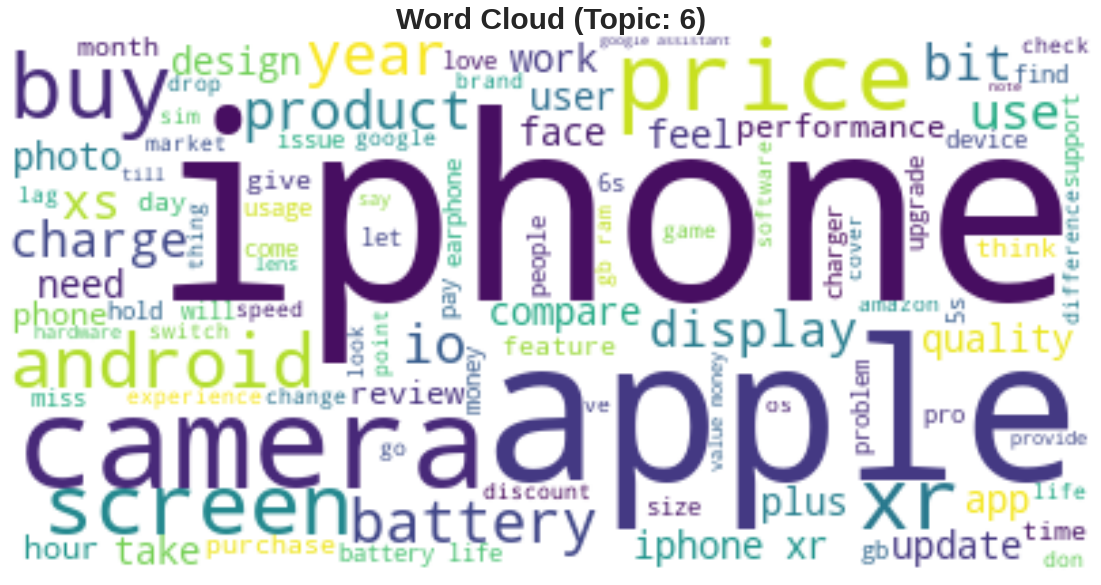

In [137]:
lda_model.generate_topic_word_cloud()

In [140]:
df['topic_index'] = lda_model.training_samples_prediction_
df['topic_names'] = df['topic_index'].apply(lambda x: topic_names[x])
df.head()

title       date location  \
0  Which iPhone you should Purchase ? iPhone 8, X... 2018-12-12    India   
1                   Don't buy iPhone xr from Amazon. 2018-11-17    India   
2                            Happy with the purchase 2019-01-27    India   
3  Amazon is not an apple authorised reseller. Pl... 2019-05-02    India   
4       Excellent Battery life and buttery smooth UI 2019-05-24    India   

   rating                                               text  \
0     3.0  NOTE:@ This is detailed comparison between iPh...   
1     1.0  Very bad experience with this iPhone xr phone....   
2     5.0  Amazing phone with amazing camera coming from ...   
3     1.0  So I got the iPhone XR just today. The product...   
4     5.0  I've been an android user all my life until I ...   

                         title_clean  \
0   iphone purchase iphone 8 x xs xr   
1         don t buy iphone xr amazon   
2                           purchase   
3         amazon apple reseller note   
4  excellent battery life buttery ui   

                                          text_clean  topic_index  \
0  note comparison iphone 8 x xs xr month state b...            6   
1  experience iphone xr camera find amazon haven ...            4   
2           camera come iphone 7 plus service amazon            4   
3  get iphone xr today product look face d work g...            4   
4  ve android user life decide try iphone xr ios ...            6   

                                         topic_names  
0  Comparison With Other Phones (One or more spec...  
1                                             Amazon  
2                                             Amazon  
3                                             Amazon  
4  Comparison With Other Phones (One or more spec...

In [146]:
for name in topic_names:
    print('topic:', name)
    print('keywords:', topics[name])
    print('sample texts:')
    for i, text in enumerate(df[df['topic_names'] == name].sample(10)['text']):
        print(f'{i+1}. {text}\n')
    print('*****\n')

topic: Product in General (Battery, Camera, Price)
keywords: "product", "battery", "camera", "quality", "price", "life", "money", "superb", "iphone", "value"
sample texts:
1. Fantastic and good deal

2. Super

3. battery is very poor, camera quality is dull.

4. Good fone

5. Good Product

6. Vhjm

7. Black colour looks elegant and phone is super fast with great battery life

8. A classic phone at a through away price.

9. The entry level product to get into Apple house of quality product.

10. Really good one for lower price im loving it ✌️

*****

topic: iPhone XR's Camera & Battery
keywords: "iphone", "xr", "love", "camera", "apple", "buy", "use", "battery", "charge"
sample texts:
1. I just love it,

2. Purchased the new iPhone XR on 21 July.Not sure battery is not at all good. Disappointed with amazo and apple both.please help me out with the exchange or refund .

3. Was a little doubtful while purchasing since i was not sure to receive a genuine Apple iPhone but received absolutel

In [130]:
fig = px.bar(df['topic_names'].value_counts())

fig.show()

In [118]:
dates = []
topics_count = []
unique_dates = np.unique(df['date'].sort_values())


for date in unique_dates:
    dates.append(date)
    topics = df.loc[df['date']==date, 'topic_index']
    if type(topics)==np.float32:
        topics = [topics]
    count = np.zeros(len(np.unique(df['topic_index'])), np.uint32)
    for idx in topics:
        count[idx] += 1
    topics_count.append(count)
    
# y = list(map(str, np.unique(df['topic_index'])))
y = list(np.unique(df['topic_names']))
df_ratings = pd.DataFrame(topics_count, dates, columns = y).resample('W').sum().reset_index()
df_ratings.columns = ['period', *y]
z = df_ratings['period'].copy()
df_ratings['period'] = df_ratings['period'].map(lambda x: str(x)[:10] + ' - ' + str(pd.offsets.DateOffset(6) + x)[:10])
df_ratings.head()

period  Amazon  Battery life, performance  \
0  2018-11-04 - 2018-11-10       0                          1   
1  2018-11-11 - 2018-11-17       0                          0   
2  2018-11-18 - 2018-11-24       0                          1   
3  2018-11-25 - 2018-12-01       0                          0   
4  2018-12-02 - 2018-12-08       1                          0   

   Comparison with Android  Comparison with other iPhones  Disappointment  \
0                        0                              0               0   
1                        0                              0               0   
2                        0                              0               1   
3                        0                              1               1   
4                        1                              0               0   

   Product in General (Battery, Camera, Price)  iPhone XR's camera & battery  
0                                            0                             0  
1                                            0                             0  
2                                            0                             0  
3                                            0                             0  
4                                            0                             1

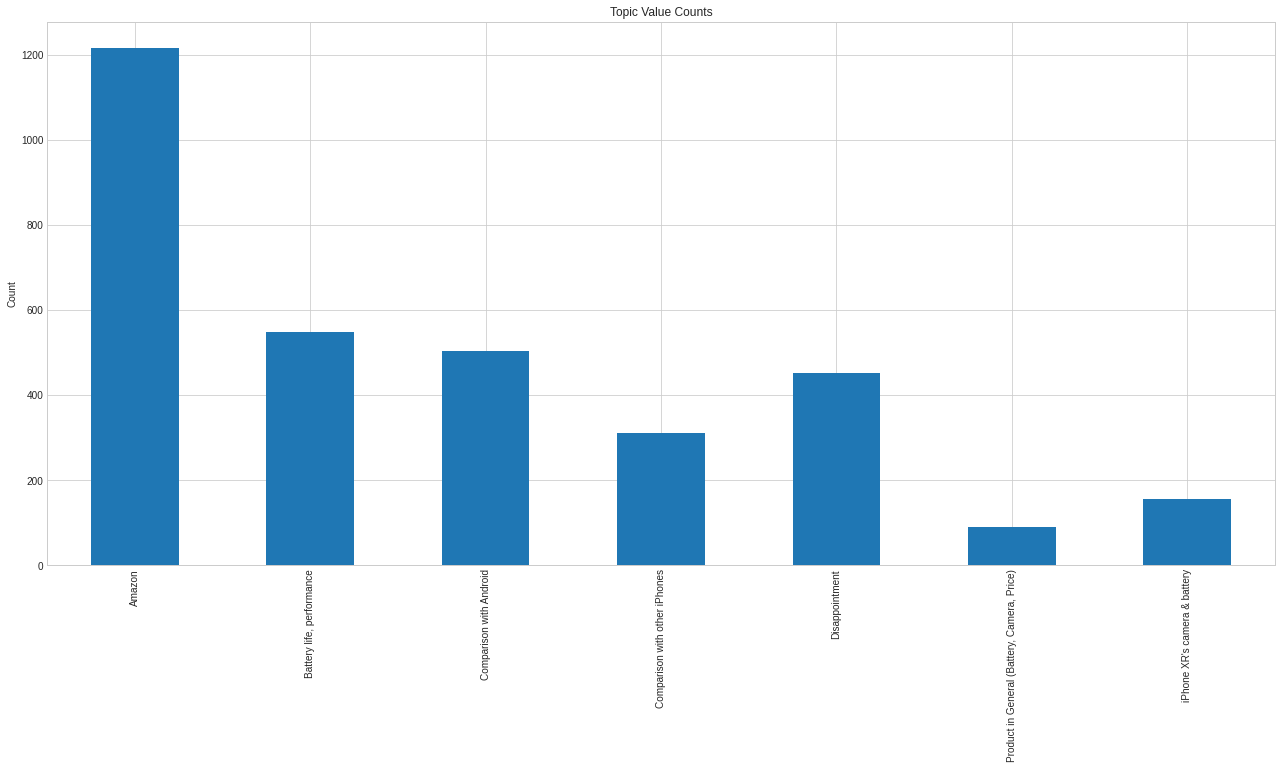

In [125]:
_ = df_ratings.iloc[:, 1:].sum().plot.bar(ylabel='Count', title='Topic Value Counts')

In [120]:
ticks = [
    ['End of Q4 2018', (2019,1,1)], 
    *[[f'End of Q{i+1} 2019', (2019 if i < 3 else 2020, 4+i*3 if i < 3 else 1, 1)] for i in range(4)], 
    *[[f'End of Q{i+1} 2020', (2020, 4+i*3 , 1)] for i in range(2)], 
]

ticktext, tickvals = [], []
for i in ticks:
    idx = np.where(z > pd.Timestamp(*i[1]))[0][0] - 1
    ticktext.append(i[0])
    tickvals.append(df_ratings['period'][idx])
    
# Generate figure
fig = px.line(df_ratings, x='period', y=y)

# Update plot title, legend, and barmode
fig.update_layout(
    title=dict(text='Product Review Count', x=0.5),
    legend=dict(
        title_text="Review Category",
        orientation="h",
        yanchor="bottom",
        y=1.0,
        xanchor="right",
        x=1.0
    ),
    barmode='stack'
)

# Update x-axis
fig.update_xaxes(
    title_text="Time",
    ticktext=ticktext,
    tickvals=tickvals,
    tickangle=-90,
#     rangeslider_visible=True,
)

# Update y-axis
fig.update_yaxes(title_text='Count')

fig.show()